# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
from ddpg_multi_agents import Multi_Agents, GaussianNoise, OUNoise
import os
import json
import os.path
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="./Reacher_Linux/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
agents_count = states.shape[0]
print('There are {} agents. Each observes a state with length: {}'.format(agents_count, state_size))
print('The state for the first agent looks like:', states[0])

Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 3. Solving the environment : find best distribution of hyper parameters

The Reacher environment is solved using a DDPG (Deep Determinic Policy Gradient). Common reinforcement learning techniques as DQN could not be applied here since it only apply to discrete action spaces in the sense that it searches for the action that maximize the action value function at each iteration.

The DDPG algorithm introduces many parameters we can play on to speed up the convergence and the final score of the trained agent :

- **buffer_size** : The size of the replay buffer in the context of the *Experience replay*,
- **batch_size** : The size of the batch involved in the update enhanced using *Experience replay*,
- **gamma** : The discount factor involved in the rewards expectation,
- **(fc1, fc2)** : the size of the first and the second layer of the fully connected neural networks that are used for the actor and for the critic.
- **lr_actor** : the learning rate of the neural netowrk of the actor,
- **lr_critic** : the learning rate of the neural netowrk of the critic,
- **noise** : the noise applied on the actor output to ease exploration, we test different parameterizations of the Ornstein-Uhlenbeck process suggested in the course but also test different gaussian noises.

### 3.1 Define hyper parameter values to test

The following cell introduces all the values we test for the hyper parameters described above :

In [5]:
# The values to test for each parameter
hyper_parameters = {
        'buffer_size':[int(1e5), int(1e6)],
        'batch_size':[64, 128, 256],
        'gamma':[0.9, 0.99, 0.995],
        '(fc1,fc2)' : [(128, 128), (128, 256), (256, 512), (512, 256), (256, 128), (512, 256)],
        'lr_actor, lr_critic' : [(1e-4, 1e-4), (1e-4, 1e-3), (1e-3, 1e-4), (1e-3, 1e-3)],
        'noise' : [GaussianNoise(action_size, 0.1),
                   GaussianNoise(action_size, 0.2),
                   GaussianNoise(action_size, 0.4),
                   GaussianNoise(action_size, 0.6),
                   GaussianNoise(action_size, 1.0),
                   GaussianNoise(action_size, 1.4),
                   OUNoise(action_size, 0, 0., 0.075, 0.1),
                   OUNoise(action_size, 0, 0., 0.15, 0.2),
                   OUNoise(action_size, 0, 0., 0.3, 0.4)
                  ]
    }

default = {
        'buffer_size':int(1e5),
        'batch_size':128,
        'gamma':0.99,
        '(fc1,fc2)' :  (256, 512),
        'lr_actor, lr_critic' : (1e-3, 1e-4),
        'noise' : GaussianNoise(action_size, 0.4)
    }

def to_name(parameters) :
    """
    built a user friendly string that describes a particular experiment,
    specified by a value distribution for parameters
    """
    return ' '.join('{}={}'.format(name, str(value)) for name, value in parameters.items())


def parameters_to_agent(parameters) :
    buffer_size = parameters['buffer_size']
    batch_size = parameters['batch_size']
    gamma = parameters['gamma']
    fc1_units, fc2_units = parameters['(fc1,fc2)']
    lr_actor, lr_critic = parameters['lr_actor, lr_critic']
    noise = parameters['noise']
    lr_actor, lr_critic = parameters['lr_actor, lr_critic']
    return Multi_Agents(agents_count, state_size, action_size, 0, buffer_size, batch_size, gamma, fc1_units, fc2_units, noise, lr_actor, lr_critic)
    

### 3.2 A stop and resume implementation for hyper-parameterization : Save partial result
Our hyper parameters tuning heuristic implies to training many times the agent. Since this is time consuming, we save the result after each training to be able to stop and resume our computations when we want without loosing what has already been computed. 

In [6]:
# load what has already been computed
if os.path.exists('hyper_parameters_tuning.json'):
    with open('hyper_parameters_tuning.json') as json_file:
        results = json.load(json_file)
else :
    results = {}


### 3.3 training routine
The following **ddpg** routine run the specified number of episodes per agent with the specified number of timeframe per episode. It is very similar to the implementation provided in the Udacity course (for instance [ddpg-pendulum](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum)) except that data like *actions*, *states*, *next_states*, *rewards*, *dones* are no longer single values but arrays (one value per agent).

Since we implemented an hyper parameters tuning, we now receive the hyper parameters of the algorithm in the routine. 

In [7]:

def ddpg(parameters,name,n_episodes=200, max_t=1000, train_mode = True, agent = None):
    if agent is None :
        agent = parameters_to_agent(parameters)
        
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] 
        states = env_info.vector_observations
        score = np.zeros(agents_count)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        #print(f'score = {score}')
        scores.append(np.mean(score))
        print(f'Episode {i_episode}\t  score = {np.mean(score)}')
        if train_mode :
            torch.save(agent.actor_local.state_dict(), f'checkpoint_actor({name}).pth')
            torch.save(agent.critic_local.state_dict(), f'checkpoint_critic({name}).pth')
        agent.reset()    
    return agent, scores




## 3.4 Evaluate each value for each hyper parameter
Train the agent for 200 iterations and save a json that gives for each experiment the value at each iteration

In [8]:
# find sequentially the "best" value for each parameters after 200 episodes. 
# When a parameter is choosen, the others take values from the dqn project

for name, parameter in hyper_parameters.items() :
    
    for value in parameter :
        key = '{}_{}'.format(name, str(value))
        if not key in results :
            print("\n\nTuning parameter {}, value = {}".format(name, value))
            parameters = default.copy()
            parameters[name] = value
            print(parameters)
            _, scores_ = ddpg(parameters, name, 200, 1000)
            results[key] = scores
            with open('hyper_parameters_tuning.json', 'w') as fp:
                json.dump(results, fp)       
        else :
            print("\nparameter {}, value = {} already tuned".format(name, value))
with open('hyper_parameters_tuning.json', 'w') as fp:
    json.dump(results, fp)       


parameter buffer_size, value = 100000 already tuned

parameter buffer_size, value = 1000000 already tuned

parameter batch_size, value = 64 already tuned

parameter batch_size, value = 128 already tuned

parameter batch_size, value = 256 already tuned

parameter gamma, value = 0.9 already tuned

parameter gamma, value = 0.99 already tuned

parameter gamma, value = 0.995 already tuned

parameter (fc1,fc2), value = (128, 128) already tuned

parameter (fc1,fc2), value = (128, 256) already tuned

parameter (fc1,fc2), value = (256, 512) already tuned

parameter (fc1,fc2), value = (512, 256) already tuned

parameter (fc1,fc2), value = (256, 128) already tuned

parameter (fc1,fc2), value = (512, 256) already tuned

parameter lr_actor, lr_critic, value = (0.0001, 0.0001) already tuned

parameter lr_actor, lr_critic, value = (0.0001, 0.001) already tuned

parameter lr_actor, lr_critic, value = (0.001, 0.0001) already tuned

parameter lr_actor, lr_critic, value = (0.001, 0.001) already tuned

p

## 4. Solving the environment : Train the model with the best hyper parameters values find before

In [9]:
best_parameters = {
        'buffer_size':int(1e5),
        'batch_size':128,
        'gamma':0.995,
        '(fc1,fc2)' :  (256, 512),
        'lr_actor, lr_critic' : (1e-3, 1e-4),
        'noise' : GaussianNoise(action_size, 0.6)
    }

agent, scores = ddpg(
    best_parameters,
    'best_param',
    200,
    1000,
    True
)
np.savetxt('best_scores.out', scores, delimiter=',')



Episode 1	  score = 0.2614999941550195
Episode 2	  score = 0.681499984767288
Episode 3	  score = 0.693499984499067
Episode 4	  score = 0.778499982599169
Episode 5	  score = 1.293499971088022
Episode 6	  score = 1.0629999762400986
Episode 7	  score = 1.7679999604821206
Episode 8	  score = 2.5759999424219133
Episode 9	  score = 3.861499913688749
Episode 10	  score = 7.27399983741343
Episode 11	  score = 7.187499839346856
Episode 12	  score = 10.901499756332488
Episode 13	  score = 16.382999633811416
Episode 14	  score = 24.210499458853157
Episode 15	  score = 27.538499384466558
Episode 16	  score = 29.815499333571644
Episode 17	  score = 34.34599923230708
Episode 18	  score = 37.20299916844815
Episode 19	  score = 39.22599912323058
Episode 20	  score = 39.092499126214534
Episode 21	  score = 39.37199911996722
Episode 22	  score = 39.30899912137538
Episode 23	  score = 39.38749911962077
Episode 24	  score = 39.37049912000075
Episode 25	  score = 39.0834991264157
Episode 26	  score = 39.23

## Plot the scores to show that it is above 30 for more than 100 iterations

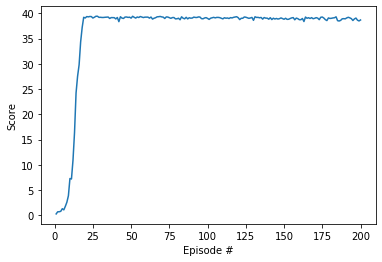

None

In [10]:


scores = list(scores)
# plot the score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
display(plt.show())

In [11]:
# run another episode ! 
_, score = ddpg(
    best_parameters,
    'best_param',
    1,
    1000,
    False,
    agent
)
print(score)


Episode 1	  score = 38.97949912874028
[38.97949912874028]
